0
**Topics**
- NLP Pre-processing Data
- Text Classification
 + Word2Vec
 + LSTM
 + BERT (Transformer - Keras)
 + BERT (Transformer - Pytorch)
 + BERT (Transformer - Simple Transformer)

In [ ]:
! pip -q install pythainlp python-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text Classification

## Preparing VM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar  3 07:43:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Command line tool for monitoring VM
! apt-get -qq install htop -y

Selecting previously unselected package libnl-genl-3-200:amd64.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../libnl-genl-3-200_3.5.0-0.1_amd64.deb ...
Unpacking libnl-genl-3-200:amd64 (3.5.0-0.1) ...
Selecting previously unselected package htop.
Preparing to unpack .../htop_3.0.5-7build2_amd64.deb ...
Unpacking htop (3.0.5-7build2) ...
Setting up libnl-genl-3-200:amd64 (3.5.0-0.1) ...
Setting up htop (3.0.5-7build2) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for hicolor-icon-theme (0.17-2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so

## Pre-processing

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Path to the CSV file in Google Drive
st = '/content/drive/MyDrive/Student_Project/Vote_check/st_vote.csv'
tr = '/content/drive/MyDrive/Student_Project/Vote_check/thairath.csv'
tns = '/content/drive/MyDrive/Student_Project/Vote_check/topnews.csv'
eig = '/content/drive/MyDrive/Student_Project/Vote_check/eigth.csv'
o = '/content/drive/MyDrive/Student_Project/Vote_check/one.csv'

# Read the CSV file into a pandas DataFrame
stdf = pd.read_csv(st, usecols=['text', 'vote','comment_id'])
thair= pd.read_csv(tr, usecols=['text', 'vote','comment_id'])
tnews = pd.read_csv(tns , usecols=['text', 'vote','comment_id'])
eigth = pd.read_csv(eig, usecols=['text', 'vote','comment_id'])
one = pd.read_csv(o, usecols=['text', 'vote','comment_id'])
# Merge DataFrames
merged_df = pd.concat([stdf, thair, tnews, eigth, one], ignore_index=True)
# Rename the 'vote' column to 'sentiment'
merged_df = merged_df.rename(columns={'vote': 'sentiment'})
merged_df = merged_df.drop_duplicates(subset='comment_id', keep='first')
print(len(stdf))
print(len(thair))
print(len(tnews))
print(len(eigth))
print(len(one))
print('รวม',len(merged_df))
merged_df


10149
53637
28944
39351
16862
รวม 134656


,comment_id,text,sentiment
0,Ugyh4l_S6n_BoyEENvp4AaABAg,ศาลก็เหมือนโจรปล้นชาติ,neg
1,UgxBWKoCa98brokBWAJ4AaABAg,เราต้องเคารพกฏแต่พวกมันไม่ต้องเล่นตามกฏประเทศไ...,neg
2,Ugx0uyvH2i22DY1Fo9F4AaABAg,งงครับเป็นสสมาได้4ปีแต่จะเป็นนายกโดนตรวจสอบถ้า...,neg
3,UgwYvslC2R3Hlmw8K7p4AaABAg,คนดีๆเค้าจะมาช่วยประชาชนไอ้พวกชั่วนี้ก็ทำแบบเด...,neg
4,Ugw1SUgwqa8y2LCZCZB4AaABAg,เหมือนธนาธรเดะๆ,neu
...,...,...,...
148938,UgyM472fzhhlJm7GC254AaABAg,แล้วที่ทำไปเป็นเรื่องดีๆทั้งนั้นเลยนะครับสงสาร...,neu
148939,Ugx5qr4_4aKmmxjGi-h4AaABAg,รักนายกพิธานะคะ,pos
148940,Ugw5xq_wdeqCYymU91Z4AaABAg,8พรรคจับมือกันได้27ล้านเสียงส่วนพรรคที่เหลือได...,neu
148941,UgwzSUMvtvL1maMoWgx4AaABAg,เสียเวลา,neg


In [ ]:
merged_df['sentiment']= merged_df['sentiment'].replace('negneg', 'neg')
merged_df['sentiment']= merged_df['sentiment'].replace('neuneu', 'neu')
merged_df['sentiment']= merged_df['sentiment'].replace('Ugz9C5TAmKoeTvFpbY54AaABAg', 'neu')
merged_df['sentiment']= merged_df['sentiment'].replace('negneu', 'neu')
merged_df['sentiment']= merged_df['sentiment'].replace('1neg', 'neg')
merged_df['sentiment']= merged_df['sentiment'].replace('UgxkLO4h_6atMp9pTNR4AaABAg', 'neg')
merged_df['sentiment']= merged_df['sentiment'].replace('Ugy2QAmA6OttftxtT354AaABAg', 'neu')
merged_df['sentiment']= merged_df['sentiment'].replace('UgwtggQRyDPrI1ZJ3SF4AaABAg', 'neu')
merged_df['sentiment']= merged_df['sentiment'].replace('Ugxh80FmUbqYxse1F0F4AaABAg', 'neg')

In [ ]:
# Assuming 'sentiment' is the column name in your DataFrame
sentiment_counts = merged_df['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)

neu    80514
neg    41081
pos    13030
Name: sentiment, dtype: int64


In [ ]:
selected_data = merged_df[merged_df['sentiment'].isin(['pos', 'neg', 'neu'])]
selected_data = selected_data.groupby('sentiment').head(13030)
selected_data

,comment_id,text,sentiment
0,Ugyh4l_S6n_BoyEENvp4AaABAg,ศาลก็เหมือนโจรปล้นชาติ,neg
1,UgxBWKoCa98brokBWAJ4AaABAg,เราต้องเคารพกฏแต่พวกมันไม่ต้องเล่นตามกฏประเทศไ...,neg
2,Ugx0uyvH2i22DY1Fo9F4AaABAg,งงครับเป็นสสมาได้4ปีแต่จะเป็นนายกโดนตรวจสอบถ้า...,neg
3,UgwYvslC2R3Hlmw8K7p4AaABAg,คนดีๆเค้าจะมาช่วยประชาชนไอ้พวกชั่วนี้ก็ทำแบบเด...,neg
4,Ugw1SUgwqa8y2LCZCZB4AaABAg,เหมือนธนาธรเดะๆ,neu
...,...,...,...
148882,Ugy7wTbOd4fuJwgPMYZ4AaABAg,ผมชอบมาก,pos
148906,Ugxqy5KQJv3wNEJQrr54AaABAg,ลุงป้มสู้ๆ,pos
148922,UgxCFTmAgVJq63nqBa54AaABAg,ขอบคุณเพื่อไทยที่ยึดมั่นจับมือกันไว้นะคะ,pos
148927,UgyCRG80MThcA4GRfMx4AaABAg,ขอให้8พรรคจับมือกันให้แน่นอย่าข้ามขั้วเป็นฝ่าย...,pos


(array([13030.,     0.,     0.,     0.,     0., 13030.,     0.,     0.,
            0., 13030.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

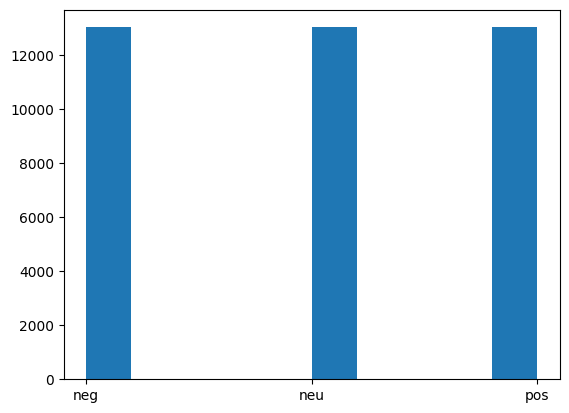

In [ ]:
plt.hist(selected_data.sentiment)

In [ ]:
stdf[stdf.text == '00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม']

,comment_id,text,vote
7450,Ugxrna9wxHZULgwEhOF4AaABAg,00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเว...,neu


In [ ]:
# train[train.text == '00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม']

In [ ]:
# plt.hist(train[train.text == '00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม'].sentiment)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# สมมติว่า selected_data คือ DataFrame ของคุณ
# selected_data = ...

# ดึงข้อมูล text และ sentiment
texts = selected_data['text'].values
labels = selected_data['sentiment'].values

# ใช้ LabelEncoder เพื่อเข้ารหัส labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# ทำการแทนค่าในคอลัม 'sentiment' ด้วย encoded_labels
selected_data['sentiment'] = encoded_labels

# แสดง DataFrame หรือตรวจสอบค่าหลังจากการแทนที่
print(len(selected_data))
selected_data.iloc[39:]


39090


,comment_id,text,sentiment
39,Ugwmlvg3gmnI3aj4nnF4AaABAg,บทเรียนครั้งนี้หวังว่าจะเป็นบทเรียนที่ราคาแพงต...,1
40,UgxRoMmx8TW7DPnQBZV4AaABAg,ไม่เป็นไรนะคะคุณพิธาเข้าใจว่าจะเป็นประชาธิปไตย...,2
41,UgwQ4cJsHvH_iv--aYh4AaABAg,เศร้าคะบอกตรงใบหน้าที่ไม่คุ้นเคย,0
42,UgxMvgwtdapRcE4049t4AaABAg,เสียใจมากค่ะ,0
43,Ugw4eyzIYJGPVKdIRLJ4AaABAg,วันนี้โลกรู้แล้วษวษษที่ชอบกินกล้วยทำชาดเสียหาย...,0
...,...,...,...
148882,Ugy7wTbOd4fuJwgPMYZ4AaABAg,ผมชอบมาก,2
148906,Ugxqy5KQJv3wNEJQrr54AaABAg,ลุงป้มสู้ๆ,2
148922,UgxCFTmAgVJq63nqBa54AaABAg,ขอบคุณเพื่อไทยที่ยึดมั่นจับมือกันไว้นะคะ,2
148927,UgyCRG80MThcA4GRfMx4AaABAg,ขอให้8พรรคจับมือกันให้แน่นอย่าข้ามขั้วเป็นฝ่าย...,2


In [ ]:
# สมมติว่า encoder เป็น LabelEncoder ที่ถูกใช้ในการเข้ารหัส
# encoded_labels เป็นค่าที่ได้จากการเข้ารหัส

# ใช้ inverse_transform เพื่อแปลงค่าที่เข้ารหัสกลับไปเป็นค่าเดิม
original_labels = encoder.inverse_transform(encoded_labels)

# ตอนนี้ original_labels จะเป็นค่าเดิมของ sentimets
print(original_labels[1000])
print(encoded_labels[1000])

pos
2


In [ ]:
def create_data(data, test_size=0.2, validation_size=0.2, random_state=42):

    # สมมติว่า DataFrame ของคุณมีคอลัมน์ที่ชื่อว่า 'text' และ 'sentiment'
    x = data[['text']]
    y = data[['sentiment']]

    # แบ่งข้อมูลเป็น train+validation และ test (โดยให้แบ่งตามคลาส)
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    # แบ่ง train+validation เป็น train และ validation (โดยให้แบ่งตามคลาส)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=validation_size/(1-test_size), random_state=random_state, stratify=y_train_val)

    # รวมคุณลักษณะและป้ายชื่อกลับมาเป็น DataFrames ของ train, validation, และ test
    train = x_train.join(y_train)
    validation = x_val.join(y_val)
    test = x_test.join(y_test)

    # บันทึกข้อมูลการฝึก, การตรวจสอบ, และการทดสอบเป็นไฟล์ CSV
    train.to_csv("train.csv", index=False)
    validation.to_csv("validation.csv", index=False)
    test.to_csv("test.csv", index=False)

    return train, validation, test

# สมมติว่า stdf คือ DataFrame ของคุณ
train, validation, test = create_data(selected_data, test_size=0.2, validation_size=0.2, random_state=42)


In [ ]:
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split

# def create_data(data, test_size=0.1):

#     # Preprocess data with csv that does not have header
#     # data = pd.read_csv(file_path)  # Add reading data from CSV file

#     # Split data with stratification to avoid class imbalance
#     x = data[['text']]
#     y = data[['sentiment']]
#     x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size, random_state=42)

#     train = x_train.join(y_train)
#     test = x_test.join(y_test)


#     # Save training and testing data as CSV files
#     train.to_csv("train.csv", index=False)
#     test.to_csv("test.csv", index=False)

#     return train, test
# train, test = create_data(stdf)

In [ ]:
print(len(train))
train

23454


,text,sentiment
16085,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,0
18973,ประหารได้ยัง,1
35091,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,0
50171,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,0
10338,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,2
...,...,...
82784,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...,2
17983,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ,1
2044,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...,2
21038,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว,1


In [ ]:
test

,text,sentiment
1366,สมัยหน้าพรรคคุณมีเก้าอี้เพิ่มแน่นอนครับ,1
1048,สมแล้วค่ะที่ชื่อพรรคเป็นธรรม,2
17952,สู้เงินไม่ได้,1
1308,สัจจะกินไม่ได้แต่มันทำให้คุณสูงส่งพูดดีทำดีเรา...,1
44907,ชอบคุนนะชาดา,2
...,...,...
49677,เขาจะหลอกให้พวกคุณเสนอจนครบยังไงสวเขาไม่เอาเพื...,0
10145,ใช่พลาดมากและผิดหวังกับประธานสภามากเลยค่ะสุดท้...,0
26901,เป็นกำลังใจให้คุณพิธาค่ะ,2
94570,ท่านพูดถูกต้องลูกหลานไทยจะต้องรู้จักประวัติศาส...,2


In [ ]:
train

,text,sentiment
16085,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,0
18973,ประหารได้ยัง,1
35091,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,0
50171,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,0
10338,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,2
...,...,...
82784,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...,2
17983,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ,1
2044,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...,2
21038,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว,1


In [ ]:
validation

,text,sentiment
47075,ตรวจสอบสวเช็คบัญชีเงินเข้าก่อนได้ดำรงตำแหน่งจน...,0
46042,ไม่ชอบเขาก็เอาเขามาประจาน555บันเทิงประเทศไทยเผ...,0
17562,จับได้สแคสเรยคับทั้งแก็งค์,1
18233,ทุนผูกขาดหากินกับคนยากคนจนมันไม่สนใจเพราะมันไม...,0
65693,เผชิญน้ำตาแห่งความสุขแสดงเก่งจริงเผชิญน้ำตาแห่...,2
...,...,...
20662,กราบขอร้องเพื่อไทยสู้ๆเกาะกัน8พรรคจะชนะนานแค่9...,2
326,นักการเมืองขั้วใหม่หรือพวกจากขั้วเก่าคราวหน้าเ...,1
17398,ผู้ใหญบ้านนามสมมุติ,1
19975,แล้วเราเลือกไปทำไม,1


### Data Distribution & Up Sampling using SMOTE

<Axes: >

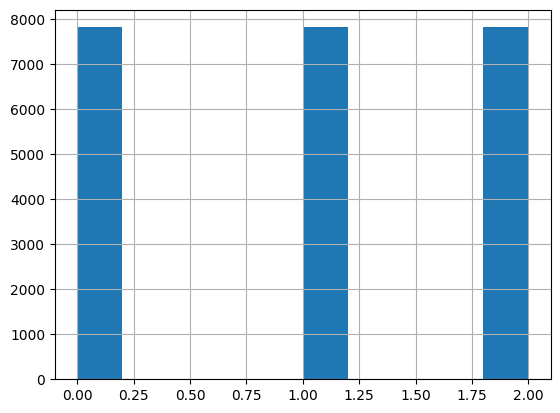

In [ ]:
train["sentiment"].hist()

<Axes: >

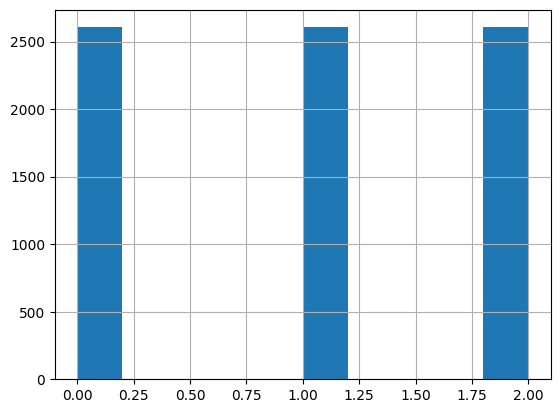

In [ ]:
test["sentiment"].hist()

<Axes: >

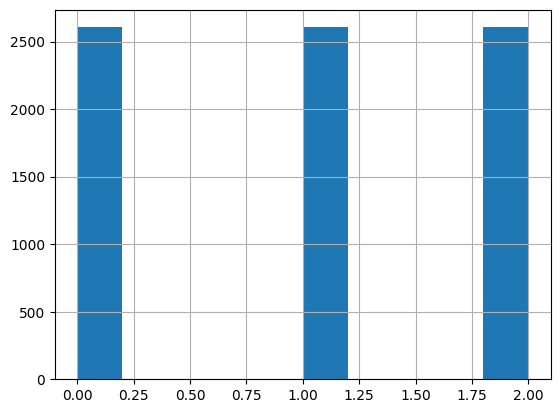

In [ ]:
validation["sentiment"].hist()

#####SMOTE

In [ ]:
#SMOTE

In [ ]:
X

array(['ใด้ใจไปเลยครับเต็มๆสมขื่อพรรคจิงๆ',
       'ถ้าไม่มีสหรัฐฯช่วยไทยในตอนนั้นคอมมิวนิสต์ก็ครอบงำไทยได้ตอนนั้นสถาบันกษัตริย์ก็ถูกล้มล้างไปในตอนนั้นแล้วซึ่งพวกสลิ่มที่อ้างรักสถาบันแต่ดันใจอยากเข้าหาจีนกับรัสเซียซึ่งเป็นประเทศที่ล้มล้างกษัตริย์ไปแล้วทั้งนั้น',
       'ยายหมดหวังอย่าเล่นการเมืองอีกเลยเดี๋ยวมีเรื่องอีก', ...,
       'สุดยอดครับ',
       '00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม',
       '00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม'],
      dtype='<U2192')

In [ ]:
y

0       1
1       1
2       0
3       1
4       1
       ..
9190    2
9191    2
9192    2
9193    2
9194    2
Name: sentiment, Length: 9195, dtype: int64

In [ ]:
import pandas as pd
train_bal = pd.DataFrame({'text': X, 'sentiment': y})

<Axes: >

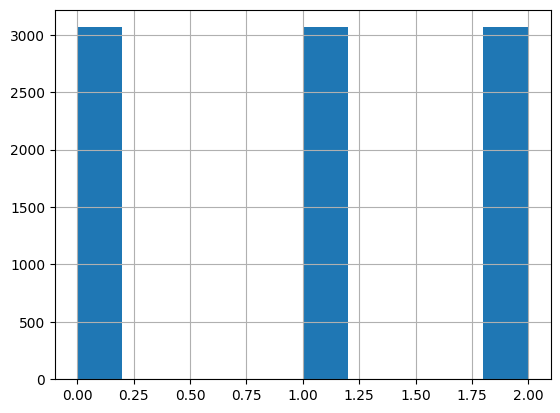

In [ ]:
train_bal['sentiment'].hist()

In [ ]:
# Making decision using either the balanced dataset or the original dataset
train = train_bal

In [ ]:
train.sample(10)

,text,sentiment
8408,00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเว...,2
2793,และนี่คือหนึ่งในเหตุผลที่พวกสสและสวข้าราชการกล...,0
5550,ม66666666,1
7318,00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเว...,2
8901,00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเว...,2
6081,00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเว...,0
2243,เสียหมาเผชิญน้ำตาแห่งความสุขเผชิญน้ำตาแห่งความสุข,0
4971,ถ้าเผารวมได้ตอนนี้เลยชาติบ้านเมืองเจริญแน่,1
5469,ขอให้บาปกรรมที่คุณกระทำวันนี้ให้ตกอยู่กับตัวคุ...,1
4670,ขอบคุณค่ะคุณกัณ,2


In [ ]:
train.iloc[7318].text

'00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม'

In [ ]:
train.iloc[6081].text

'00555ฐานทัพสหรัฐฯในไทยเริ่มตั้งแต่ก่อนสงครามเวียดนาม1032ไทยในเงาสงครามเวียดนาม2038สงครามเวียดนามสหรัฐฯแทรกแซงไทยขนาดไหน2226ฐานทัพสหรัฐฯทิ้งอะไรไว้ให้ไทย255504การกลับหัวกลับหางของฝ่ายขวาไทย335552การแทรกแซงเปลี่ยนไปแล้ว4330ในอนาคตสหรัฐฯจะกลับมาตั้งฐานทัพในไทยไหม'

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Assuming you have a list of texts and corresponding labels
texts = [...]  # List of texts
labels = [...]  # List of corresponding labels

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features parameter
X = vectorizer.fit_transform(texts)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a classifier (e.g., Naive Bayes) on the resampled data
clf = MultinomialNB()
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


In [ ]:
# Up sampling & Down sampling of text data using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer

sm = SMOTE(random_state = 2)
lb = LabelBinarizer()

# Waiting for 1 min and consume high memory
# If you not in Colab Pro, it will failed due to not enough memory:
# may be resize the size of training down to just see how it works
# e.g., train_balance = train[:1000]

X_train = lb.fit_transform(train["text"])
X_train_bin, y = sm.fit_resample(X_train, train["sentiment"])
X = lb.inverse_transform(X_train_bin)

#### Cleaning Data

In [ ]:
len(train)

24834

In [ ]:
import re
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def clean_me(data):
  data['clean_text'] = data.str.replace(r'<[^<>]*>', '', regex=True)
  data['clean2_text']= data['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
  data['clean3_text'] = data.apply(lambda row: deEmojify(row['clean2_text']), axis=1)
  return(data)

In [ ]:
# Remove all HTML tag
#a = data['b'].str.replace(r'<[^<>]*>', '', regex=True)
train['clean_text'] = train['text'].str.replace(r'<[^<>]*>', '', regex=True)
test['clean_text'] = test['text'].str.replace(r'<[^<>]*>', '', regex=True)
validation['clean_text'] = validation['text'].str.replace(r'<[^<>]*>', '', regex=True)

# Remove all excessive space, special characters and new line symbols
train['clean2_text'] = train['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
test['clean2_text'] = test['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
validation['clean2_text'] = validation['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')

<ipython-input-49-459f6b5bdbeb>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train['clean2_text'] = train['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
<ipython-input-49-459f6b5bdbeb>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  test['clean2_text'] = test['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
<ipython-input-49-459f6b5bdbeb>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  validation['clean2_text'] = validation['clean_text'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')


In [ ]:
#Remove emoji
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

train['clean3_text'] = train.apply(lambda row: deEmojify(row['clean2_text']), axis=1)
test['clean3_text'] = test.apply(lambda row: deEmojify(row['clean2_text']), axis=1)
validation['clean3_text'] = validation.apply(lambda row: deEmojify(row['clean2_text']), axis=1)


In [ ]:
train

,text,sentiment,clean_text,clean2_text,clean3_text
16085,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,0,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...
18973,ประหารได้ยัง,1,ประหารได้ยัง,ประหารได้ยัง,ประหารได้ยัง
35091,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,0,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...
50171,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,0,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...
10338,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,2,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...
...,...,...,...,...,...
82784,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...,2,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...,ดีครับร้านรุ้งจะได้ไม่ไปกินขอบคุณด้อมส้มจากใจใ...
17983,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ,1,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ,รู้ว่ามีหุ้นพิธาไม่จัดการโอนหรือตั้งใจ
2044,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...,2,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...,4ปีข้างหน้าคุณจะได้คะแนนเพิ่มอีกมายเพาะคุณมีจุ...
21038,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว,1,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว,เขาเสี้ยมให้กับพทแตกกันอยู่แล้ว


### Text Normalization / Word Segmentation / Stop words filtering

In [ ]:
! pip -q install pythainlp python-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.6 MB/s eta 0:00:00


In [ ]:
from pythainlp.util import normalize
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize

stopwords = list(thai_stopwords())
stopwords.append("nan")
stopwords.append("-")
stopwords.append("_")
stopwords.append("")
stopwords.append(" ")

# Normalize text
train['clean4_text'] = train.apply(lambda row: normalize(row['clean3_text']), axis=1) #clean3_text
test['clean4_text'] = test.apply(lambda row: normalize(row['clean3_text']), axis=1)
validation['clean4_text'] = validation.apply(lambda row: normalize(row['clean3_text']), axis=1)


# Word segmentation: it will take a while....
train['wordseged_text'] = train.apply(lambda row: word_tokenize(row['clean4_text'],engine="newmm-safe"), axis=1)
test['wordseged_text'] = test.apply(lambda row: word_tokenize(row['clean4_text'],engine="newmm-safe"), axis=1)
validation['wordseged_text'] = validation.apply(lambda row: word_tokenize(row['clean4_text'],engine="newmm-safe"), axis=1)

# Remove stopwords, it will take a very long time.....
#train['wordseged_nostopword_text'] = train.apply(lambda row: [i for i in train['wordseged_text'] if i not in stopwords], axis=1)
#test['wordseged_nostopword_text'] = test.apply(lambda row: [i for i in test['wordseged_text'] if i not in stopwords], axis=1)

# Join the wordsegged with space
train['wordseged_space_text'] = train.apply(lambda row: " ".join(row["wordseged_text"]), axis=1)
test['wordseged_space_text'] = test.apply(lambda row: " ".join(row["wordseged_text"]), axis=1)
validation['wordseged_space_text'] = validation.apply(lambda row: " ".join(row["wordseged_text"]), axis=1)


In [ ]:
# train1 = train.drop(columns=['wordseged_nostopword_text'] )
# test1 = test.drop(columns=['wordseged_nostopword_text'])
# train1.head()

In [ ]:
# # Save training and testing data as CSV files
# train1.to_csv("train_.csv", index=False)
# test1.to_csv("test_.csv", index=False)


In [ ]:
test['sentiment']

1366     1
1048     2
17952    1
1308     1
44907    2
        ..
49677    0
10145    0
26901    2
94570    2
15242    1
Name: sentiment, Length: 7818, dtype: int64

In [ ]:
validation

,text,sentiment,clean_text,clean2_text,clean3_text,clean4_text,wordseged_text,wordseged_space_text
31502,เอาจนได้ประเทศซิบหายพอดีออกไปเถอะไปอยู่ฝ่ายค้าน,0,เอาจนได้ประเทศซิบหายพอดีออกไปเถอะไปอยู่ฝ่ายค้าน,เอาจนได้ประเทศซิบหายพอดีออกไปเถอะไปอยู่ฝ่ายค้าน,เอาจนได้ประเทศซิบหายพอดีออกไปเถอะไปอยู่ฝ่ายค้าน,เอาจนได้ประเทศซิบหายพอดีออกไปเถอะไปอยู่ฝ่ายค้าน,"[เอา, จนได้, ประเทศ, ซิบ, หาย, พอดี, ออก, ไป, ...",เอา จนได้ ประเทศ ซิบ หาย พอดี ออก ไป เถอะ ไป อ...
126242,คุณชาดาทำถูกต้องครับ,2,คุณชาดาทำถูกต้องครับ,คุณชาดาทำถูกต้องครับ,คุณชาดาทำถูกต้องครับ,คุณชาดาทำถูกต้องครับ,"[คุณ, ชา, ดา, ทำ, ถูกต้อง, ครับ]",คุณ ชา ดา ทำ ถูกต้อง ครับ
2091,คนที่มีมือพับ,1,คนที่มีมือพับ,คนที่มีมือพับ,คนที่มีมือพับ,คนที่มีมือพับ,"[คน, ที่, มี, มือ, พับ]",คน ที่ มี มือ พับ
19128,มันจะมีผู้หญิงบางประเภทที่ชอบคบคนแกที่มีตังแล้...,1,มันจะมีผู้หญิงบางประเภทที่ชอบคบคนแกที่มีตังแล้...,มันจะมีผู้หญิงบางประเภทที่ชอบคบคนแกที่มีตังแล้...,มันจะมีผู้หญิงบางประเภทที่ชอบคบคนแกที่มีตังแล้...,มันจะมีผู้หญิงบางประเภทที่ชอบคบคนแกที่มีตังแล้...,"[มัน, จะ, มี, ผู้หญิง, บาง, ประเภท, ที่, ชอบ, ...",มัน จะ มี ผู้หญิง บาง ประเภท ที่ ชอบ คบ คน แก ...
17543,ไซนาไนเปล่า,1,ไซนาไนเปล่า,ไซนาไนเปล่า,ไซนาไนเปล่า,ไซนาไนเปล่า,"[ไซ, นา, ไน, เปล่า]",ไซ นา ไน เปล่า
...,...,...,...,...,...,...,...,...
13076,สู้ๆนะคะคุณพิธา,2,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,"[สู้, ๆ, นะคะ, คุณ, พิธา]",สู้ ๆ นะคะ คุณ พิธา
67622,สวสุดยอดครับ,2,สวสุดยอดครับ,สวสุดยอดครับ,สวสุดยอดครับ,สวสุดยอดครับ,"[สว, สุดยอด, ครับ]",สว สุดยอด ครับ
58358,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,2,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,"[หนักแน่น, ชัดเจน, นี่, คือ, คนรุ่นใหม่, นี่, ...",หนักแน่น ชัดเจน นี่ คือ คนรุ่นใหม่ นี่ คือ อนา...
33404,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,0,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,"[ตำรวจ, น่าจะ, ตะโกน, ด่า, ด้อม, ส้ม, จาก, ด้า...",ตำรวจ น่าจะ ตะโกน ด่า ด้อม ส้ม จาก ด้านใน ออกม...


## Word2Vec

In [ ]:
# import pandas as pd
# train= pd.read_csv('/content/train_.csv')
# test= pd.read_csv('/content/test_.csv')

In [ ]:
train.head()

,text,sentiment,clean_text,clean2_text,clean3_text,clean4_text,wordseged_text,wordseged_space_text
16085,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,0,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,"[ฉิบหาย, และ, เอา, พระพุทธ, มา, เล่น, แล้ว, บอ...",ฉิบหาย และ เอา พระพุทธ มา เล่น แล้ว บอ กว่า พร...
18973,ประหารได้ยัง,1,ประหารได้ยัง,ประหารได้ยัง,ประหารได้ยัง,ประหารได้ยัง,"[ประหาร, ได้, ยัง]",ประหาร ได้ ยัง
35091,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,0,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,"[ฟัง, สีส้ม, มา, เขา, บอก, เบื้องบน, มี, คำสั่...",ฟัง สีส้ม มา เขา บอก เบื้องบน มี คำสั่ง ให้ สว...
50171,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,0,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,"[ก้าวไกล, ดีแต่, พูด, เอาแต่ใจตัวเอง, อ้าง, แต...",ก้าวไกล ดีแต่ พูด เอาแต่ใจตัวเอง อ้าง แต่ 14 ล...
10338,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,2,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,"[คน, ที่, มี, มือ, พับ, ขอบคุณ, ท่าน, ที่, เห็...",คน ที่ มี มือ พับ ขอบคุณ ท่าน ที่ เห็น ค่า เสี...


In [ ]:
!pip install pythainlp python-crfsuite

In [ ]:
from pythainlp import word_vector
import numpy as np


In [ ]:
wv = word_vector.WordVector()

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


  0%|          | 0/62452646 [00:00<?, ?it/s]

In [ ]:
####  Word to Vec object
word2vec = wv.get_model()

In [ ]:
def get_average_vector(cleaned_query):
    sum_query = None
    count=0
    for query in cleaned_query:
        try:
            if (sum_query is None):
                sum_query = np.copy(word2vec[query])
            else:
                sum_query += word2vec[query]
            count+=1
            print("Word "+query+ " found!")
        except:
            print("Word "+query+" is not found!")
    if (sum_query is not None):
        average_query = sum_query/count
    else:
        average_query = np.zeros((300,))
    return average_query

average_query = get_average_vector(["ทดสอบ","ดู","นะ","ครับ"])
print(average_query)

Word ทดสอบ found!
Word ดู found!
Word นะ found!
Word ครับ found!
[ 0.0729435   0.10315551  0.09200675  0.20117874  0.0884465  -0.02690875
 -0.19606349  0.1138515  -0.142324    0.1712055  -0.02833    -0.08175799
 -0.0646225   0.13941674 -0.00328775 -0.21250674  0.11129924  0.08854325
  0.10727476 -0.31458575 -0.01692325 -0.08343    -0.027316    0.2538085
 -0.17720951 -0.09206425 -0.1467155   0.07075325 -0.1685635   0.007884
  0.187906   -0.265904   -0.01858099  0.03022575 -0.1081155   0.11422776
  0.15058425  0.06027399  0.12092424  0.08924175 -0.01036475 -0.208514
  0.1412115   0.004442   -0.17056376 -0.18328774 -0.02664525 -0.316675
 -0.07512475  0.0436375  -0.08636225  0.02774225  0.01774126 -0.19483599
  0.0950405   0.18499452  0.015365   -0.099916    0.1140205  -0.11109875
  0.0566305  -0.07291149 -0.01777725 -0.2032655   0.05336475 -0.235581
 -0.1757015   0.1420705   0.18264925 -0.2221965   0.058705    0.20701227
  0.18176325 -0.40199196  0.247788    0.05174225  0.12133725  0.1273

In [ ]:
from functools import reduce

# Make average vectors of each class
avg_w = {}
for i in range(3):
  avg_w[i] = reduce(lambda x,y: x+y, validation[validation["sentiment"]==i][:100]['wordseged_text'])

In [ ]:
from functools import reduce

# Make average vectors of each class
avg_w = {}
for i in range(3):
  avg_w[i] = reduce(lambda x,y: x+y, train[train["sentiment"]==i][:100]['wordseged_text'])

In [ ]:
avg_v = {}
for i in range(3):
  print(i, len(avg_w[i]))
  avg_v[i] = get_average_vector(avg_w[i])

Streaming output truncated to the last 5000 lines.
Word เสียง found!
Word คน found!
Word แบบนี้ found!
Word สมควร found!
Word ตายห่า is not found!
Word คับ found!
Word สมควร found!
Word แล้ว found!
Word สะใจ found!
Word ๆๆ is not found!
Word สะใจ found!
Word คับ found!
Word เป็นหนี้ found!
Word เขา found!
Word ไม่ found!
Word พอ found!
Word ยัง found!
Word ไป found!
Word ยิง found!
Word เขา found!
Word อีก found!
Word สุด found!
Word ตนเอง found!
Word ตายห่า is not found!
Word ลงนรก found!
Word สะ found!
Word เดินตาม found!
Word เกม found!
Word ที่ found!
Word เขา found!
Word วาง found!
Word ไก่อ่อน is not found!
Word การเมือง found!
Word ไม่ found!
Word มีทาง found!
Word ชนะ found!
Word โดน found!
Word ดักทาง is not found!
Word ไว้ found!
Word หมด found!
Word แล้ว found!
Word เขา found!
Word รู้ found!
Word อยู่แล้ว is not found!
Word ว่า found!
Word คุณ found!
Word จะ found!
Word ทำ found!
Word อะไร found!
Word ต่อ found!
Word ทางเลือก found!
Word มัน found!
Word ไม่ found!
Word ได้ 

In [ ]:
def cosine_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
qv = get_average_vector(['ประธาน', 'ไม่', 'แข็งแรง', 'พอ', 'คือ', 'ขี้กลัว', 'ทำไม', 'ไม่', 'ใช้อำนาจ', 'ประธาน', 'สภา', 'เลย', 'โหวต', 'ทำไม'])
qv

Word ประธาน found!
Word ไม่ found!
Word แข็งแรง found!
Word พอ found!
Word คือ found!
Word ขี้กลัว found!
Word ทำไม found!
Word ไม่ found!
Word ใช้อำนาจ found!
Word ประธาน found!
Word สภา found!
Word เลย found!
Word โหวต found!
Word ทำไม found!


array([-4.14662138e-02, -9.14689973e-02,  1.37804776e-01,  1.04663923e-01,
       -7.73859993e-02, -1.84707828e-02, -9.32375044e-02,  1.47187576e-01,
        1.58618644e-01,  1.04839154e-01, -7.00547919e-02, -2.78875828e-02,
       -1.14069648e-01,  2.66537428e-01,  2.29003560e-02, -5.21606430e-02,
       -7.62185687e-03,  1.87574148e-01,  5.30173592e-02, -1.41423615e-02,
        7.05442131e-02,  2.01325074e-01,  2.33720779e-01,  8.49712044e-02,
       -4.22993563e-02, -5.55021456e-03,  1.34801418e-02, -8.74360725e-02,
       -7.10224956e-02, -1.54721260e-01, -4.27442743e-03, -4.24873568e-02,
        4.68072109e-02, -6.09971471e-02, -1.45606622e-01,  2.74278224e-03,
       -4.62030694e-02,  1.32879719e-01,  3.08797825e-02, -1.56740714e-02,
       -1.30744204e-01,  2.92803552e-02, -5.49608544e-02, -2.69419312e-01,
       -9.62093547e-02, -2.02414528e-01, -8.43503475e-02,  4.76102158e-02,
       -6.71087876e-02, -3.50087881e-02, -9.95436125e-03, -1.57952178e-02,
        6.01284280e-02, -

In [ ]:
for i in range(3):
    print(i, cosine_sim(qv, avg_v[i]))

0 0.7639129
1 0.726343
2 0.7087428


## LSTM

In [ ]:
! pip install pythainlp python-crfsuite

(array([2.2496e+04, 7.7700e+02, 1.4200e+02, 1.9000e+01, 1.1000e+01,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  46.4,  91.8, 137.2, 182.6, 228. , 273.4, 318.8, 364.2,
        409.6, 455. ]),
 <BarContainer object of 10 artists>)

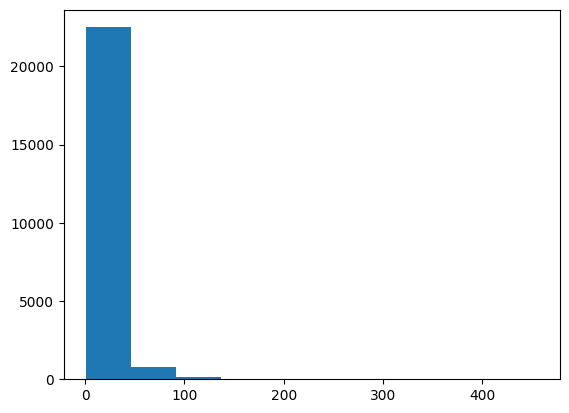

In [ ]:
train_t = train.copy()
temp = train_t.wordseged_text.apply(lambda x : len(x)).values
plt.hist(temp)

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(23)
from pythainlp import word_vector
import numpy as np
#word2vec = word_vector.get_model()


In [ ]:
print("Vocab in Thai2Vec:",len(word2vec.key_to_index))

Vocab in Thai2Vec: 51358


In [ ]:
'''def sentences_to_indices(X, word2vec, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`.

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()[:max_len]

        # Initialize j to 0
        j = 0

        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word2vec:
              X_indices[i, j] = word2vec.wv.vocab[w].index
              # Increment j to j + 1
              j = j + 1

    return X_indices'''

'def sentences_to_indices(X, word2vec, max_len):\n    """\n    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.\n    The output shape should be such that it can be given to `Embedding()`.\n\n    Arguments:\n    X -- array of sentences (strings), of shape (m, 1)\n    word_to_index -- a dictionary containing the each word mapped to its index\n    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.\n\n    Returns:\n    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)\n    """\n\n    m = X.shape[0]                                   # number of training examples\n\n    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)\n    X_indices = np.zeros((m, max_len))\n\n    for i in range(m):                               # loop over training examples\n\n        # Convert the ith training sentence in lowe

In [ ]:
'''
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def sentences_to_indices(X, y, word2vec, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`. It also applies SMOTE for oversampling.

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    y -- array of labels corresponding to sentences, of shape (m,)
    word2vec -- a trained Word2Vec model from gensim
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    y_one_hot -- one-hot encoded labels corresponding to sentences
    """

    m = X.shape[0]  # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples

        # Convert the ith training sentence in lower case and split it into words. You should get a list of words.
        sentence_words = X[i].lower().split()[:max_len]

        # Initialize j to 0
        j = 0

        try:
            # Loop over the words of sentence_words
            for w in sentence_words:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                if w in word2vec.key_to_index:
                    X_indices[i, j] = word2vec.key_to_index[w]
                    # Increment j to j + 1
                    j += 1
        except:
            print('key error: ', w)

    # Apply SMOTE for oversampling
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_indices, y)

    # Convert labels to one-hot encoding
    y_one_hot = convert_to_one_hot(y_resampled, max(y_resampled) - min(y_resampled) + 1)

    return X_resampled, y_one_hot
'''

'\nimport numpy as np\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.model_selection import train_test_split\n\ndef sentences_to_indices(X, y, word2vec, max_len):\n    """\n    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.\n    The output shape should be such that it can be given to `Embedding()`. It also applies SMOTE for oversampling.\n\n    Arguments:\n    X -- array of sentences (strings), of shape (m, 1)\n    y -- array of labels corresponding to sentences, of shape (m,)\n    word2vec -- a trained Word2Vec model from gensim\n    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.\n\n    Returns:\n    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)\n    y_one_hot -- one-hot encoded labels corresponding to sentences\n    """\n\n    m = X.shape[0]  # number of training examples\n\n    # Initialize X_indices 

In [ ]:
import numpy as np

def sentences_to_indices(X, word2vec, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`.

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word2vec -- a trained Word2Vec model from gensim
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]                                   # number of training examples

    # Initialize X_indices as a numpy matrix of zeros and the correct shape
    X_indices = np.zeros((m, max_len))

    for i in range(m):                               # loop over training examples

        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        # print(X)
        # print(len(X[i].lower().split()))
        sentence_words = X[i].lower().split()[:max_len]

        # Initialize j to 0
        j = 0
        try:
        # Loop over the words of sentence_words
          for w in sentence_words:
              # Set the (i,j)th entry of X_indices to the index of the correct word.

                if w in word2vec.key_to_index:
                    X_indices[i, j] = word2vec.key_to_index[w]
                    # Increment j to j + 1
                    j += 1
        except:
              print('key error: ', w)


    return X_indices


In [ ]:
'ฏ' in word2vec.key_to_index

True

In [ ]:
X1 = np.array(["สวัสดี ครับ ผม", "ทดสอบ ทดสอบ ทดสอบ", "เรา มา ทดสอบ กัน","8"])
X1_indices = sentences_to_indices(X1, word2vec, max_len = 10)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['สวัสดี ครับ ผม' 'ทดสอบ ทดสอบ ทดสอบ' 'เรา มา ทดสอบ กัน' '8']
X1_indices = [[10966.  7412.  1478.     0.     0.     0.     0.     0.     0.     0.]
 [ 1481.  1481.  1481.     0.     0.     0.     0.     0.     0.     0.]
 [  512.    28.  1481.    67.     0.     0.     0.     0.     0.     0.]
 [  169.     0.     0.     0.     0.     0.     0.     0.     0.     0.]]


In [ ]:
def convert_to_one_hot(y, maxLen):
    max_value = max(y)
    min_value = min(y)
    length = len(y)
    one_hot = np.zeros((length, (max_value - min_value + 1)))
    one_hot[np.arange(length), y] = 1
    return one_hot

In [ ]:
word2vec["สวัสดี"]

array([-0.085646,  0.026953,  0.028896,  0.044996,  0.049635,  0.045211,
        0.023309, -0.090897, -0.05953 ,  0.08087 , -0.136755, -0.040957,
        0.032874,  0.006045, -0.052973,  0.008588,  0.051925,  0.031071,
        0.011009, -0.003462,  0.077638, -0.017447, -0.035472,  0.043032,
       -0.060651, -0.108809,  0.04371 ,  0.016992, -0.047803,  0.027662,
        0.023731, -0.037916,  0.04465 , -0.238991, -0.057065, -0.04388 ,
       -0.116942,  0.056753,  0.129576, -0.056548,  0.049498,  0.059565,
       -0.056575, -0.011652, -0.009675,  0.014921,  0.126478, -0.062158,
       -0.089027,  0.213171, -0.003804, -0.05275 ,  0.096998,  0.005888,
       -0.064087,  0.023647,  0.021911,  0.028926,  0.168334, -0.078046,
       -0.097861,  0.059737, -0.041758, -0.028375, -0.089168, -0.099481,
       -0.128708, -0.028006, -0.034368, -0.012488,  0.01938 , -0.011861,
        0.031278,  0.063505, -0.202193, -0.027805,  0.013007,  0.084966,
        0.007958,  0.012287, -0.019016,  0.053675, 

In [ ]:
 word2vec.key_to_index.items()

dict_items([('ที่', 0), ('และ', 1), ('เป็น', 2), ('ของ', 3), ('มี', 4), ('ได้', 5), ('""""', 6), ('การ', 7), ('(', 8), (')', 9), ('โดย', 10), ('ส', 11), ('น', 12), ('กับ', 13), ('จะ', 14), ('ปี', 15), ('ว่า', 16), ('จาก', 17), (',', 18), ('ซึ่ง', 19), ('ให้', 20), ('', 21), ('พ.ศ.', 22), ('ไป', 23), ('.', 24), ('อ', 25), ('-', 26), ('เมื่อ', 27), ('มา', 28), ('์', 29), ('หรือ', 30), ('พระ', 31), ('ก็', 32), ('อยู่', 33), ('ร์', 34), ('นี้', 35), ('คือ', 36), ('เ', 37), ('แต่', 38), ('ใช้', 39), ('ค.ศ.', 40), ('ยัง', 41), ('คน', 42), ('ด้วย', 43), ('เขา', 44), ('วันที่', 45), ('ถูก', 46), ('ไม่', 47), ('แห่ง', 48), ('เพื่อ', 49), ('ๆ', 50), ('จึง', 51), ('ทาง', 52), ('ขึ้น', 53), (':', 54), ('2', 55), ('ได้รับ', 56), ('นั้น', 57), ('1', 58), ('ผู้', 59), ('สามารถ', 60), ('แล้ว', 61), ('ท', 62), ('เมือง', 63), ('ล', 64), ('บ', 65), ('ช', 66), ('กัน', 67), ('ทำให้', 68), ('3', 69), ('ประเทศ', 70), ('ถึง', 71), ('ทรง', 72), ('เธอ', 73), ('หนึ่ง', 74), ('ชื่อ', 75), ('เรื่อง', 76), ('เพลง',

In [ ]:
word2vec["ประชาชน"].shape[0]

300

In [ ]:
vocab_len = len(word2vec.key_to_index) + 1
emb_dim = word2vec["สวัสดี"].shape[0]
emb_matrix = np.zeros((vocab_len, emb_dim))

In [ ]:
for word, index in word2vec.key_to_index.items():
      #print(word, index)
      emb_matrix[index, :] = word2vec[word]

In [ ]:
def pretrained_embedding_layer(word2vec):
    """
    Creates a Keras Embedding() layer and loads in pre-trained PyThaiNLP word_vector 300-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """

    vocab_len = len(word2vec.key_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word2vec["ประชาชน"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word2vec.key_to_index.items():
        # print(word)
        emb_matrix[index, :] = word2vec[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word2vec)
print("weights[0][1] =", embedding_layer.get_weights()[0][1])
# print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1] = [ 1.075100e-02 -6.189710e-01  1.296650e-01  3.546000e-02 -7.560000e-03
  2.760700e-02  3.978240e-01  2.654300e-02  2.540750e-01  1.683280e-01
 -9.858800e-02  2.570410e-01 -5.643300e-02  4.745000e-03 -1.944960e-01
 -9.463100e-02 -2.232210e-01  1.371390e-01 -7.294200e-02  2.684000e-03
 -7.887400e-02  1.081800e-02 -3.718210e-01  2.227020e-01 -1.310570e-01
 -1.781660e-01  7.801000e-03 -3.930770e-01  5.299490e-01 -3.101930e-01
  1.333700e-02 -1.813800e-02 -3.000430e-01 -5.032500e-02 -5.512390e-01
  2.832700e-01 -2.433820e-01  3.772650e-01  1.396830e-01  5.905610e-01
  2.934620e-01  2.302000e-03  2.777800e-01 -1.603492e+00 -6.830400e-02
 -6.939320e-01 -2.383000e-02  1.889580e-01 -1.672810e-01 -2.962500e-02
 -7.274390e-01 -6.587900e-02 -8.408900e-02  3.744550e-01  1.746500e-01
  1.294800e-02  3.895010e-01 -5.417900e-02 -4.989100e-02 -6.464240e-01
  1.128650e+00 -1.341001e+00 -2.358630e-01 -9.856200e-02 -5.247900e-02
 -4.950500e-02  3.165200e-02 -1.782880e-01 -1.089700e-02  4.8

In [ ]:
def text_clasifier_lstm(input_shape, word2vec):
    """
    Function creating the Emojify-v2 model's graph.

    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """

    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)

    # Create the embedding layer pretrained with Word2Vec Vectors
    embedding_layer =  pretrained_embedding_layer(word2vec)

    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.1
    X = Dropout(0.1)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.1
    X = Dropout(0.1)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3, activation='softmax')(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)

    return model

In [ ]:
model = text_clasifier_lstm((128,), word2vec)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 300)          15407700  
                                                                 
 lstm (LSTM)                 (None, 128, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387   

In [ ]:
train['wordseged_space_text']

16085    ฉิบหาย และ เอา พระพุทธ มา เล่น แล้ว บอ กว่า พร...
18973                                       ประหาร ได้ ยัง
35091    ฟัง สีส้ม มา เขา บอก เบื้องบน มี คำสั่ง ให้ สว...
50171    ก้าวไกล ดีแต่ พูด เอาแต่ใจตัวเอง อ้าง แต่ 14 ล...
10338    คน ที่ มี มือ พับ ขอบคุณ ท่าน ที่ เห็น ค่า เสี...
                               ...                        
82784    ดี ครับ ร้าน รุ้ง จะ ได้ ไม่ ไป กิน ขอบคุณ ด้อ...
17983      รู้ ว่า มี หุ้น พิธา ไม่ จัดการ โอน หรือ ตั้งใจ
2044     4 ปี ข้างหน้า คุณ จะ ได้ คะแนน เพิ่ม อีก มาย เ...
21038                เขา เสี้ยม ให้ กับ พท แตกกัน อยู่แล้ว
5985                     มีเกียรติ อย่างยิ่ง ครับ คุณ พิธา
Name: wordseged_space_text, Length: 23454, dtype: object

In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/Student_Project/Vote_check

/content/drive/MyDrive/Student_Project/Vote_check


In [ ]:
import tensorflow as tf
# optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
X_train_indices = sentences_to_indices(train['wordseged_space_text'].values, word2vec, 128)
Y_train_oh = convert_to_one_hot((train['sentiment']), 3)
# ถ้า X_train_indices และ Y_train_oh เป็นข้อมูลการฝึกของคุณ
history = model.fit(X_train_indices, Y_train_oh, epochs=500, batch_size=32, shuffle=True, validation_split=0.2)
# บันทึกโมเดลลง disk
model.save('New_model.h5')

Epoch 1/300
  7/621 [..............................] - ETA: 11:24 - loss: 1.0873 - accuracy: 0.3705

KeyboardInterrupt: 

In [ ]:
# stacking the series vertically
merged_train = pd.concat([train, validation], axis = 0)
print("\nStack two series vertically:")
display(merged_train)


Stack two series vertically:


,text,sentiment,clean_text,clean2_text,clean3_text,clean4_text,wordseged_text,wordseged_space_text
16085,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,0,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,ฉิบหายและเอาพระพุทธมาเล่นแล้วบอกว่าพระพุทธเจ้า...,"[ฉิบหาย, และ, เอา, พระพุทธ, มา, เล่น, แล้ว, บอ...",ฉิบหาย และ เอา พระพุทธ มา เล่น แล้ว บอ กว่า พร...
18973,ประหารได้ยัง,1,ประหารได้ยัง,ประหารได้ยัง,ประหารได้ยัง,ประหารได้ยัง,"[ประหาร, ได้, ยัง]",ประหาร ได้ ยัง
35091,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,0,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,ฟังสีส้มมาเขาบอกเบื้องบนมีคำสั่งให้สวยกมือให้พ...,"[ฟัง, สีส้ม, มา, เขา, บอก, เบื้องบน, มี, คำสั่...",ฟัง สีส้ม มา เขา บอก เบื้องบน มี คำสั่ง ให้ สว...
50171,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,0,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,ก้าวไกลดีแต่พูดเอาแต่ใจตัวเองอ้างแต่14ล้านเสีย...,"[ก้าวไกล, ดีแต่, พูด, เอาแต่ใจตัวเอง, อ้าง, แต...",ก้าวไกล ดีแต่ พูด เอาแต่ใจตัวเอง อ้าง แต่ 14 ล...
10338,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,2,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,คนที่มีมือพับขอบคุณท่านที่เห็นค่าเสียงของประชา...,"[คน, ที่, มี, มือ, พับ, ขอบคุณ, ท่าน, ที่, เห็...",คน ที่ มี มือ พับ ขอบคุณ ท่าน ที่ เห็น ค่า เสี...
...,...,...,...,...,...,...,...,...
13076,สู้ๆนะคะคุณพิธา,2,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,สู้ๆนะคะคุณพิธา,"[สู้, ๆ, นะคะ, คุณ, พิธา]",สู้ ๆ นะคะ คุณ พิธา
67622,สวสุดยอดครับ,2,สวสุดยอดครับ,สวสุดยอดครับ,สวสุดยอดครับ,สวสุดยอดครับ,"[สว, สุดยอด, ครับ]",สว สุดยอด ครับ
58358,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,2,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,หนักแน่นชัดเจนนี่คือคนรุ่นใหม่นี่คืออนาคตของปร...,"[หนักแน่น, ชัดเจน, นี่, คือ, คนรุ่นใหม่, นี่, ...",หนักแน่น ชัดเจน นี่ คือ คนรุ่นใหม่ นี่ คือ อนา...
33404,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,0,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,ตำรวจน่าจะตะโกนด่าด้อมส้มจากด้านในออกมาด้านนอก...,"[ตำรวจ, น่าจะ, ตะโกน, ด่า, ด้อม, ส้ม, จาก, ด้า...",ตำรวจ น่าจะ ตะโกน ด่า ด้อม ส้ม จาก ด้านใน ออกม...


In [ ]:
import tensorflow as tf
model3 = text_clasifier_lstm((128,), word2vec)
model3.summary()
# optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)
model3.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
X_train_indices = sentences_to_indices(merged_train['wordseged_space_text'].values, word2vec, 128)
Y_train_oh = convert_to_one_hot((merged_train['sentiment']), 3)
# ถ้า X_train_indices และ Y_train_oh เป็นข้อมูลการฝึกของคุณ
history3 = model3.fit(X_train_indices, Y_train_oh, epochs=500, batch_size=32, shuffle=True, validation_split=0.2)
# บันทึกโมเดลลง disk
model3.save('my_model4.h5')

#filehandler = open('model4.pickle', 'wb')
#pickle.dump(model3, filehandler)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 300)          15407700  
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          219648    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387 

In [ ]:
import pickle
filehandler = open('history.pickle', 'wb')
pickle.dump(history2, filehandler)


In [ ]:
filehandler = open('history.pickle', 'rb')
loaded_history = pickle.load(filehandler)

266/266 [==============================] - 1s 5ms/step
Confusion Matrix:
[[2231  538   67]
 [ 603 1964  269]
 [  47  285 2505]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2836
           1       0.70      0.69      0.70      2836
           2       0.88      0.88      0.88      2837

    accuracy                           0.79      8509
   macro avg       0.79      0.79      0.79      8509
weighted avg       0.79      0.79      0.79      8509



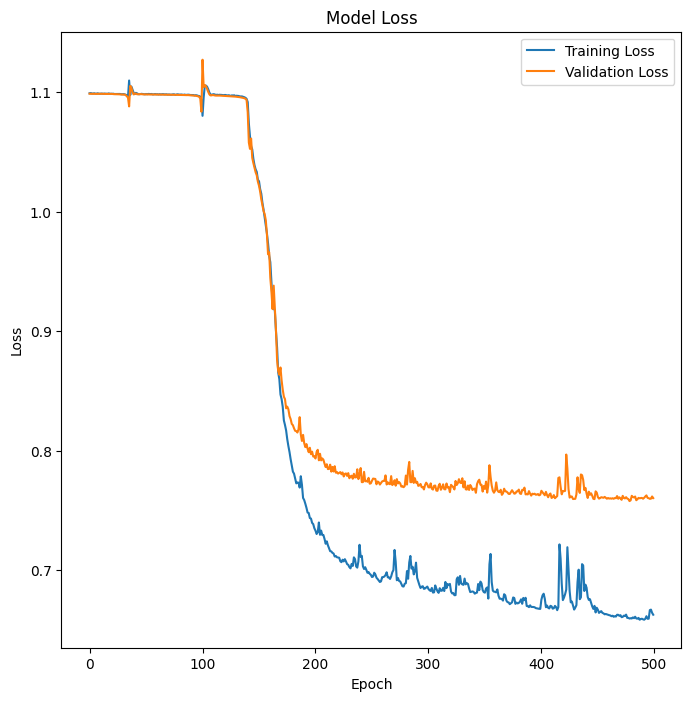

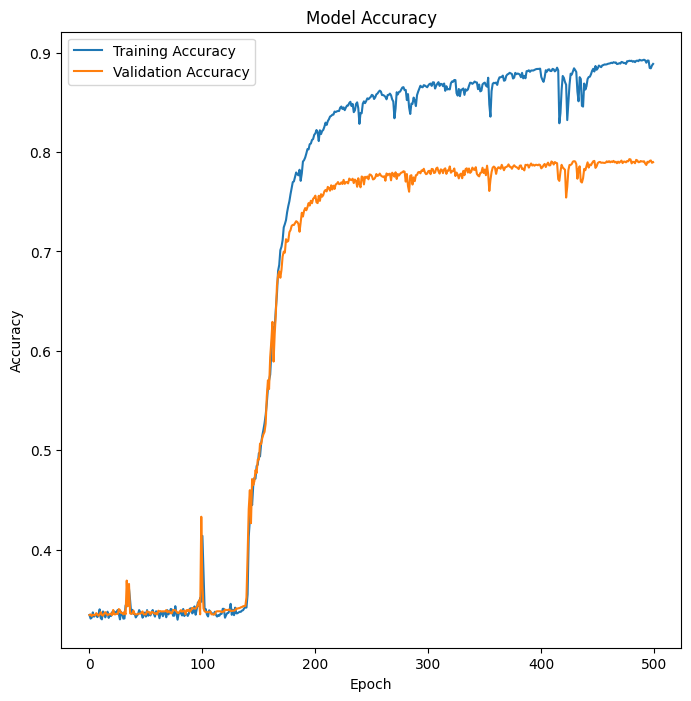

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


def plot_learningCurve(histoty):

  # Extract loss and accuracy values from the training history
  train_loss_values = histoty.history['loss']
  train_accuracy_values = histoty.history['accuracy']
  val_loss_values = histoty.history['val_loss']
  val_accuracy_values = histoty.history['val_accuracy']

  # Plot training and validation loss
  plt.figure(figsize=(8, 8))

  # plt.subplot(1, 2, 1)
  plt.plot(train_loss_values, label='Training Loss')
  plt.plot(val_loss_values, label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  # Plot training and validation accuracy
  # plt.subplot(1, 2, 2)
  plt.figure(figsize=(8, 8))
  plt.plot(train_accuracy_values, label='Training Accuracy')
  plt.plot(val_accuracy_values, label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()



def compute_Confusion(test,model):

  test2 = np.array(test['wordseged_space_text'])
  # Assuming you have test data
  X_test_indices = sentences_to_indices(test2, word2vec, 128)

  # One-hot encode the 'sentiment' column
  Y_test_oh = pd.get_dummies(test['sentiment']).values

  # Make predictions on the test set
  Y_pred = model.predict(X_test_indices)

  # Convert one-hot encoded predictions and true labels back to class labels
  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true_classes = np.argmax(Y_test_oh, axis=1)
  rp02 =( Y_true_classes == 0) & (Y_pred_classes == 2)
  #print(test2[rp02])
  # Confusion Matrix
  conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
  print("Confusion Matrix:")
  print(conf_matrix)

  # Classification Report with Precision, Recall, and F1-Score
  class_report = classification_report(Y_true_classes, Y_pred_classes)
  print("\nClassification Report:")
  print(class_report)

compute_Confusion(test, model2)
plot_learningCurve(history2)

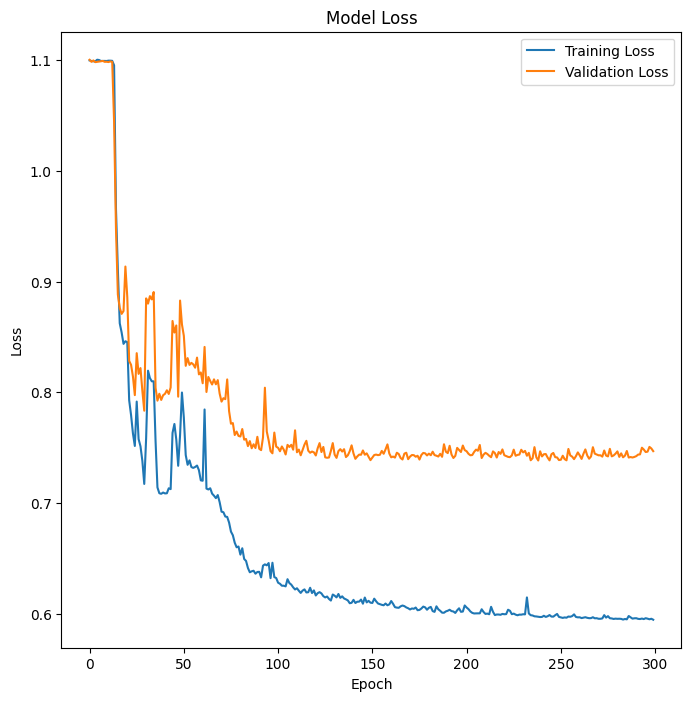

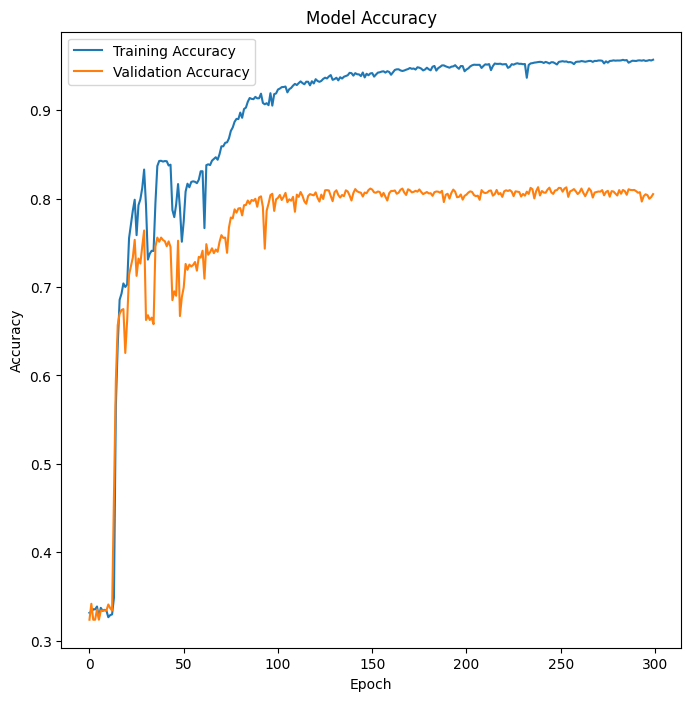

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the training history
train_loss_values = history.history['loss']
train_accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(8, 8))

# plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot training and validation accuracy
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 8))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


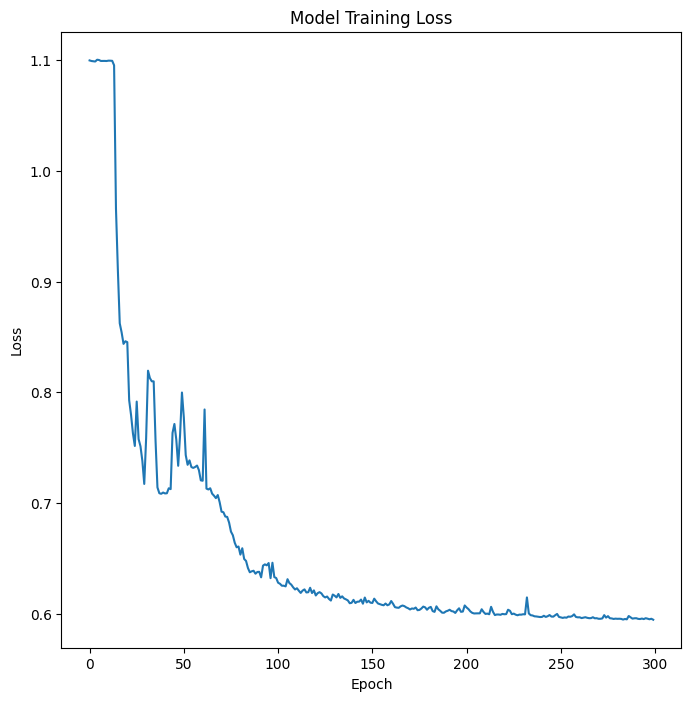

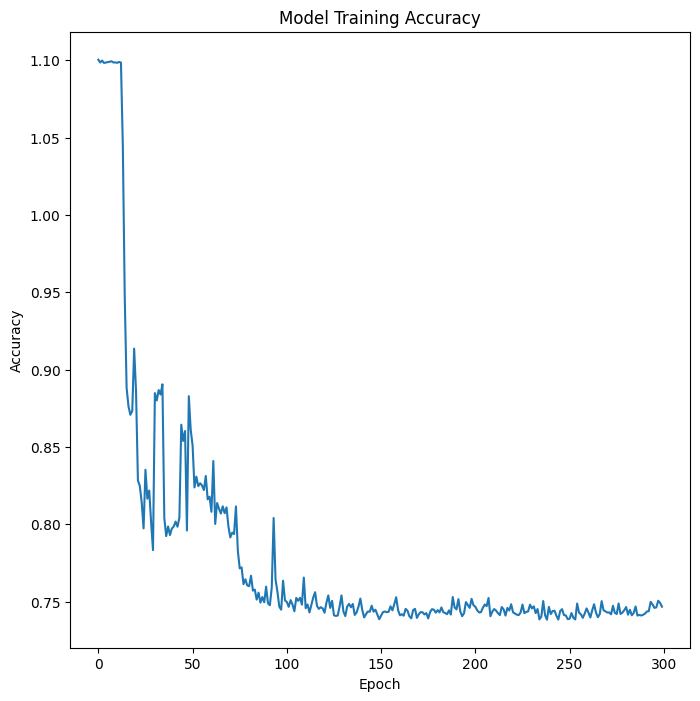

In [ ]:
# Extract loss and accuracy values from the training history
train_loss_values = history.history['loss']
train_accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']
# Plot training loss
plt.figure(figsize=(8, 8))
plt.plot(train_loss_values)
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy
plt.figure(figsize=(8, 8))
plt.plot(val_loss_values)
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
X_train_indices

array([[4.0200e+02, 4.1400e+02, 2.8700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.4000e+01, 3.2000e+01, 4.2600e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.1200e+02, 1.4000e+01, 1.3250e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [7.2670e+03, 8.4600e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.7900e+02, 4.7000e+01, 1.0720e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.8240e+03, 4.5053e+04, 7.2670e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [ ]:
preds = model.predict(X_train_indices[:10])
preds

1/1 [==============================] - 1s 691ms/step


array([[0.5759337 , 0.21206291, 0.21200338],
       [0.21202616, 0.21213607, 0.57583773],
       [0.57593375, 0.21206291, 0.21200338],
       [0.57593846, 0.21205913, 0.21200235],
       [0.57593447, 0.21206237, 0.21200317],
       [0.21204236, 0.5756845 , 0.21227324],
       [0.57593393, 0.21206279, 0.21200334],
       [0.21205081, 0.21220241, 0.57574683],
       [0.57593375, 0.21206288, 0.21200337],
       [0.5759333 , 0.21206324, 0.21200356]], dtype=float32)

In [ ]:
word2vec

In [ ]:
validation['wordseged_space_text'][101:102]

124    โอ มาม่า คนผิวดำ ยัง ไป ได้ คิดดู
Name: wordseged_space_text, dtype: object

In [ ]:
type(validation)

pandas.core.frame.DataFrame

In [ ]:
type(test)

pandas.core.frame.DataFrame

In [ ]:
test2 = np.array(test['wordseged_space_text'][101:102])
sentences_to_indices(test2, word2vec, 128)

array([[  656.,  6835.,   805.,   236., 12425.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

In [ ]:
test['wordseged_space_text'][0:100]

2856    ขอให้ พวก สว ตาย อย่าง ทร มาร คนรัก ค่อย ล้มหา...
6680    ศิธา อย่า ล้อเล่น กับ ความ ไม่ ศรัทธา ของ ประช...
4589    ใช่ แหละ เพื่อน ฝรั่ง ไปเที่ยว กทม เจอ ตำรวจ เ...
6300    สงสาร ประชาชน บ้าง เลือก มา อยู่ ๆ ลุง จะ มา เ...
5040    งาน นี้ จะ ไม่ คร บิ ทิม จบ แบบ ไม 148 ต่อ แผ่...
                              ...                        
6829    ถ้า เพื่อ ไทย เปลี่ยนใจ ผม ก็ เปลี่ยนใจ ไม่ เล...
9246    วัฒนธรรม ไทย ยัง นิยม ความ นอบน้อม ให้เกียรติ ...
2956                                   อยุ่คัำ ฟ้า ไป เลย
6228                                            555 สิ ทา
5156    คนเรา ถ้า ไม่ รักษาคำพูด ที่ พูด ออกมา ก็ หมา ...
Name: wordseged_space_text, Length: 100, dtype: object

In [ ]:
train['wordseged_space_text']

0       เออ จะ เอา อย่างนี้ อย่า พูดถึง ความถูกต้อง นั...
1       หน้า ค่าย รามสูร ตั้งแต่ เลย วัด บ้าน โนน สูง ...
2       ผู้คน ในประเทศ รู้ ได้ ว่า สภา เลวร้าย มาก ใบ ...
3                มัน มั่ว ไป หมด เผชิญ น้ำตา แห่ง ความสุข
4       เลือก กี่ ปี่ ก็ ไม่ มี ทางได้ เป็น หรอก เก้าอ...
                              ...                        
8296                                                    0
8297                                                    0
8298                                                    0
8299                                                    0
8300                                     สุดยอด ครับ ท่าน
Name: wordseged_space_text, Length: 8301, dtype: object

In [ ]:
# Assuming Y_test_oh is a DataFrame
Y_test_oh = convert_to_one_hot(test['sentiment'], 3)
print("One-Hot Encoded Labels:")
print(Y_test_oh)

# Assuming test['sentiment'] is the original sentiment labels
print("Original Sentiment Labels:")
print(test['sentiment'].head())


One-Hot Encoded Labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
Original Sentiment Labels:
621     2
4385    0
8201    0
4562    1
8161    0
Name: sentiment, dtype: int64


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
test2 = np.array(test['wordseged_space_text'])
# Assuming you have test data
X_test_indices = sentences_to_indices(test2, word2vec, 128)

# One-hot encode the 'sentiment' column
Y_test_oh = pd.get_dummies(test['sentiment']).values

# Make predictions on the test set
Y_pred = model2.predict(X_test_indices)

# Convert one-hot encoded predictions and true labels back to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test_oh, axis=1)
rp02 =( Y_true_classes == 0) & (Y_pred_classes == 2)
print(test2[rp02])
# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report with Precision, Recall, and F1-Score
class_report = classification_report(Y_true_classes, Y_pred_classes)
print("\nClassification Report:")
print(class_report)


266/266 [==============================] - 2s 5ms/step
['เคย เจอ ตอน ไป ทัศนศึกษา ค่ะ แก่ สุด มาก'
 'ผม อยาก ให้ คุณ พิธา ได้ ลอง ทำงาน คน ที่ ไม่ ชอบ จะ ได้ รู้ ว่า เขา ทำงาน ตาม นโยบาย ที่ ให้ ไว้ ได้ มั้ย ถ้า ไม่ ได้ ศรัทธา ความนิยม เขา ก็ จะ หาย ไป เอง แต่ ถ้า ทำได้ ก็ เป็นผลดี กับ ส่วนรวม ถ้า เขา ไม่ ได้ ลอง ทำงาน สักที ก็ จะ มี คลื่นใต้น้ำ สงสัย ไป ตลอด ว่า ถ้า คุณ พิธา ได้ เป็น นายก ชีวิต จะ ดีกว่า ตอนนี้ แค่ ไหน ป้า ๆ ยาย ๆ ที่ เลือก เพราะ เบี้ย คนชรา เด็กผู้ชาย ที่ อยาก ให้ ยกเลิก เกณฑ์ทหาร หรือ ค่าแรง 45550 สำหรับ ผู้มีรายได้ น้อยกว่า 15550 บาท เดือน เลือกตั้ง ครั้ง ต่อไป ถ้า เขา ไม่ ตาย ไป ก่อน ก็ จะ เลือก อยู่ดี'
 'มี นายก ดี ๆ มี ความคิด ก้าวหน้า แต่ ก็ ไม่ อยากได้ กลัว ประเทศ จะ เจริญ ชอบ นายก ที่ ย่ำอยู่กับที่ นี่แหละ ประเทศ ไทย น่าเบื่อ สุด ๆ'
 'ถาม ใจ ตัง เอง ดู ว่า ชอบ คอม หรือ ชอบ เสรี ส่วน ตัวเรา ไม่ ชอบ อะไร ที่มา เอาเปรียบ กดหัว ไม่ เอื้อเฟื้อเผื่อแผ่'
 'น่า สาร จัง คุณ นายก ใน ดวงใจ พิธา ใบ หน้าที่ ร้องไห้'
 'คนเก่ง คน ฉลาด ไม่ อยาก เอา เป็น ผู้นำ ชอบ เอา คนโง่ ม

In [ ]:
test['sentiment'].sample(10)

In [ ]:
np.argmax(preds, axis=1)